In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from utils.consensus_node import ConsensusNode
from utils.master_node import MasterNode
from networks.ann_model import ANNModel

In [2]:
ABC_5 = {'Alice':   {'Alice': 0.5,  'Bob': 0.25, 'Charlie': 0.25},
         'Bob':     {'Alice': 0.25, 'Bob': 0.5,  'Charlie': 0.25},
         'Charlie': {'Alice': 0.25, 'Bob': 0.25, 'Charlie': 0.5}}

In [3]:
ABC_9 = {'Alice':   {'Alice': .9,   'Bob': 0.05, 'Charlie': 0.05},
         'Bob':     {'Alice': 0.05, 'Bob': .9,   'Charlie': 0.05},
         'Charlie': {'Alice': 0.05, 'Bob': 0.05, 'Charlie': .9}}

In [4]:
CYCLE4_5 = {'North': {'North': 0.5, 'East':  0.25, 'West':  0.25},
            'East':  {'East':  0.5, 'North': 0.25, 'South': 0.25},
            'South': {'South': 0.5, 'East':  0.25, 'West':  0.25},
            'West':  {'West':  0.5, 'South': 0.25, 'North': 0.25}}

In [5]:
FULL4_52 = {'North': {'North': 0.52, 'East':  0.16, 'West':  0.16, 'South': 0.16},
            'East':  {'East':  0.52, 'North': 0.16, 'South': 0.16, 'West':  0.16},
            'South': {'South': 0.52, 'East':  0.16, 'West':  0.16, 'North': 0.16},
            'West':  {'West':  0.52, 'South': 0.16, 'North': 0.16, 'East':  0.16}}

In [6]:
topology = ABC_9

In [7]:
input_dim = 28*28
# hidden layer dim is one of the hyper parameter and it should be chosen and tuned.
# For now I only say 150 there is no reason.
hidden_dim = 150 
output_dim = 10

# Create ANN
model = ANNModel
model_args = [input_dim, hidden_dim, output_dim]

# Cross Entropy Loss 
error = nn.CrossEntropyLoss

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD

In [8]:
# load data
train = pd.read_csv(r"../data/digits/train.csv", dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

In [9]:
n_agents = len(topology)
batch_size = 100

In [10]:
train_loaders = {}
for token, features, targets in zip(topology,
                                    np.array_split(features_train, n_agents),
                                    np.array_split(targets_train, n_agents)):
    featuresTrain = torch.from_numpy(features)
    targetsTrain = torch.from_numpy(targets).type(torch.LongTensor) # data type is long
    
    train = torch.utils.data.TensorDataset(featuresTrain, targetsTrain)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
    train_loaders[token] = train_loader

In [11]:
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

test = torch.utils.data.TensorDataset(featuresTest, targetsTest)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)


In [12]:
master = MasterNode(node_names=topology.keys(),
                    model=model,
                    model_args=model_args,
                    optimizer=optimizer,
                    error=error,
                    weights=topology,
                    train_loaders=train_loaders,
                    test_loader=test_loader,
                    stat_step=100,
                    niter=3000
                   )

In [13]:
master.initialize_nodes()

In [14]:
master.start_consensus()

Step: 100, Node Alice: accuracy 11.12, loss 2.30
Step: 100, Node Bob: accuracy 12.36, loss 2.30
Step: 100, Node Charlie: accuracy 11.98, loss 2.30
Step: 200, Node Alice: accuracy 10.83, loss 2.29
Step: 200, Node Bob: accuracy 10.83, loss 2.30
Step: 200, Node Charlie: accuracy 10.83, loss 2.30
Step: 300, Node Alice: accuracy 10.87, loss 2.30
Step: 300, Node Bob: accuracy 10.88, loss 2.29
Step: 300, Node Charlie: accuracy 10.88, loss 2.29
Step: 400, Node Alice: accuracy 13.68, loss 2.29
Step: 400, Node Bob: accuracy 14.46, loss 2.29
Step: 400, Node Charlie: accuracy 13.33, loss 2.29
Step: 500, Node Alice: accuracy 20.39, loss 2.28
Step: 500, Node Bob: accuracy 21.69, loss 2.27
Step: 500, Node Charlie: accuracy 21.76, loss 2.28
Step: 600, Node Alice: accuracy 26.87, loss 2.26
Step: 600, Node Bob: accuracy 27.71, loss 2.27
Step: 600, Node Charlie: accuracy 27.64, loss 2.28
Step: 700, Node Alice: accuracy 30.12, loss 2.20
Step: 700, Node Bob: accuracy 29.95, loss 2.18
Step: 700, Node Charli

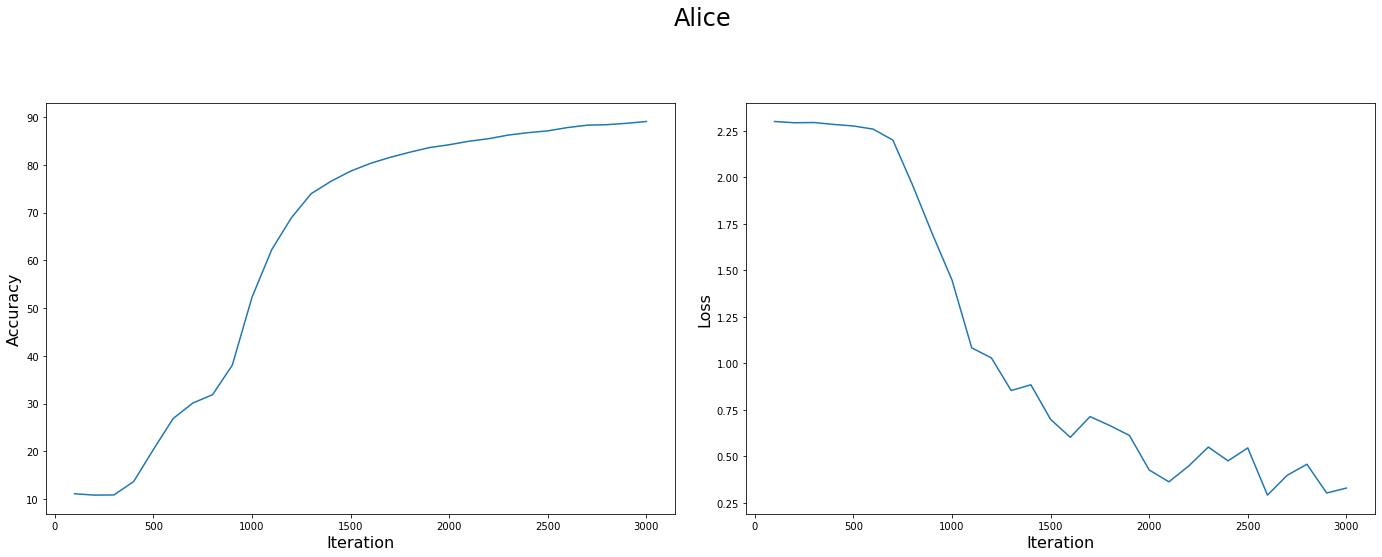

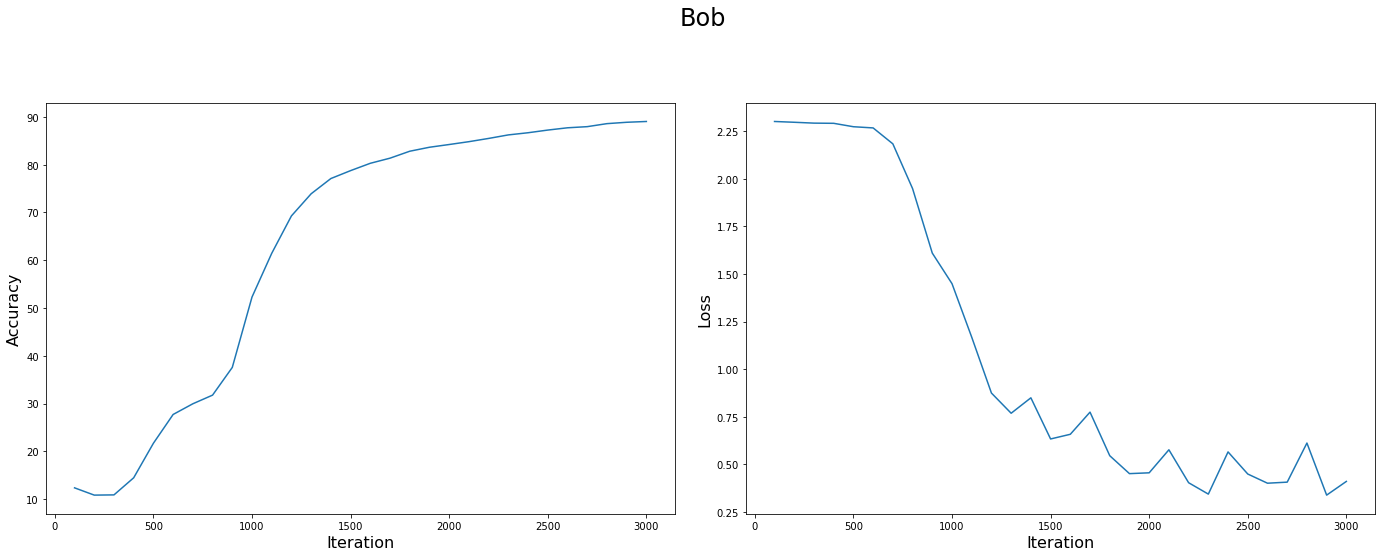

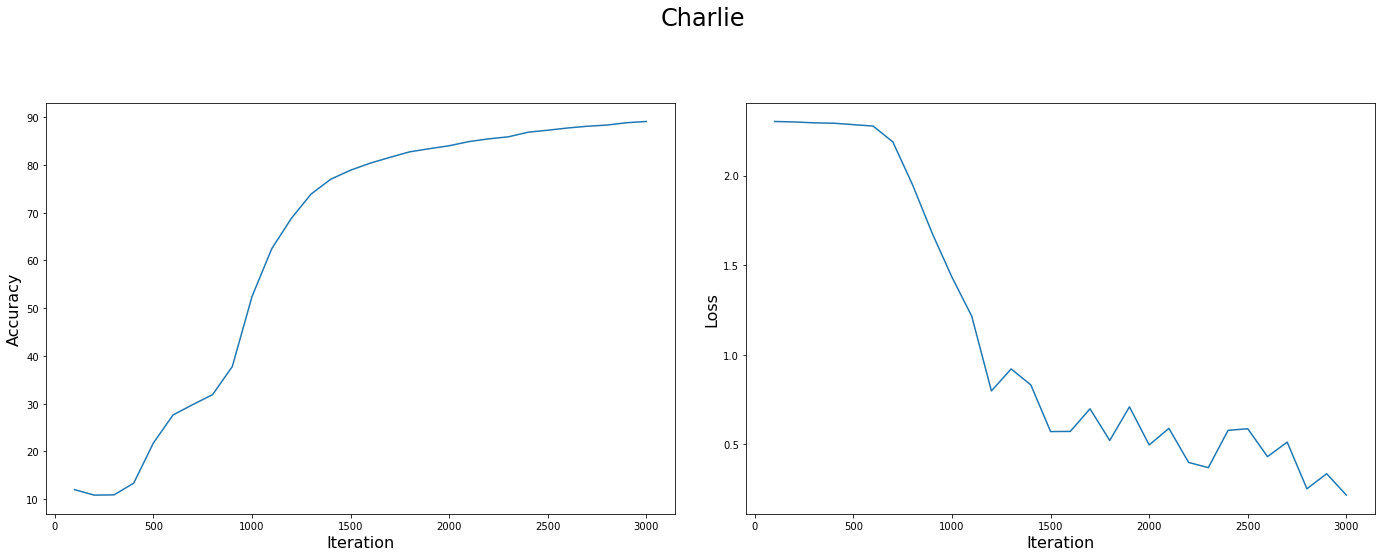

In [15]:
for node in master.network.values():
    node.show_graphs()